In [1]:
from load_data import parameters_dict, simulation_file_paths

import numpy as np
# import saved feature array
feature_arr = np.load("feature_arr.npy")

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(feature_arr)
distances, indices = neighbors_fit.kneighbors(feature_arr)

distances_sorted = np.sort(distances, axis=0)

dbscan = DBSCAN(eps=0.64, min_samples=5)

dbscan.fit(feature_arr)
dbscan.labels_.max()

12

In [10]:
from plot_class import plot_class
class_dict = {f"Class {i}": list() for i in range(dbscan.labels_.max() + 1)}
class_dict["Outliers"] = list()
for index, path in enumerate(simulation_file_paths):
    class_ = dbscan.labels_[index]
    if class_ == -1:
        class_dict["Outliers"].append(str(path))
    else:
        class_dict[f"Class {class_}"].append(str(path))


plot_class(class_dict)

AttributeError: 'DBSCAN' object has no attribute 'labels_'

In [5]:
# hyperparameter optimization
import optuna
from sklearn.metrics import silhouette_score


def objective(trial):
    eps = trial.suggest_float("eps", 0.5, 1.5)
    min_samples = trial.suggest_int("min_samples", 2, 10)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(feature_arr)
    metric = silhouette_score(feature_arr, labels)
    return metric


# search_space = {"eps": (0.5, 1.5), "min_samples": (2, 10)}
study = optuna.create_study(direction="maximize", study_name="DBSCAN_ss",
                            storage="sqlite:///dbscan_ss.db", load_if_exists=True)
study.optimize(objective, n_trials=100)

[I 2024-04-04 04:57:48,260] Using an existing study with name 'DBSCAN_ss' instead of creating a new one.
[I 2024-04-04 04:57:48,699] Trial 301 finished with value: 0.37299495935440063 and parameters: {'eps': 0.5383410524965277, 'min_samples': 2}. Best is trial 91 with value: 0.43654105067253113.
[I 2024-04-04 04:57:48,937] Trial 302 finished with value: 0.37299495935440063 and parameters: {'eps': 0.573659018452746, 'min_samples': 2}. Best is trial 91 with value: 0.43654105067253113.
[I 2024-04-04 04:57:49,180] Trial 303 finished with value: 0.37299495935440063 and parameters: {'eps': 0.5209690746207687, 'min_samples': 2}. Best is trial 91 with value: 0.43654105067253113.
[I 2024-04-04 04:57:49,429] Trial 304 finished with value: 0.37299495935440063 and parameters: {'eps': 0.5511336596130079, 'min_samples': 2}. Best is trial 91 with value: 0.43654105067253113.
[I 2024-04-04 04:57:49,701] Trial 305 finished with value: 0.33536556363105774 and parameters: {'eps': 1.2390434068376714, 'min_

In [9]:
dbscan = DBSCAN(eps=study.best_params["eps"], min_samples=study.best_params["min_samples"])

from plot_class import plot_class
class_dict = {f"Class {i}": list() for i in range(dbscan.labels_.max() + 1)}
class_dict["Outliers"] = list()
for index, path in enumerate(simulation_file_paths):
    class_ = dbscan.labels_[index]
    if class_ == -1:
        class_dict["Outliers"].append(str(path))
    else:
        class_dict[f"Class {class_}"].append(str(path))


plot_class(class_dict)

AttributeError: 'DBSCAN' object has no attribute 'labels_'

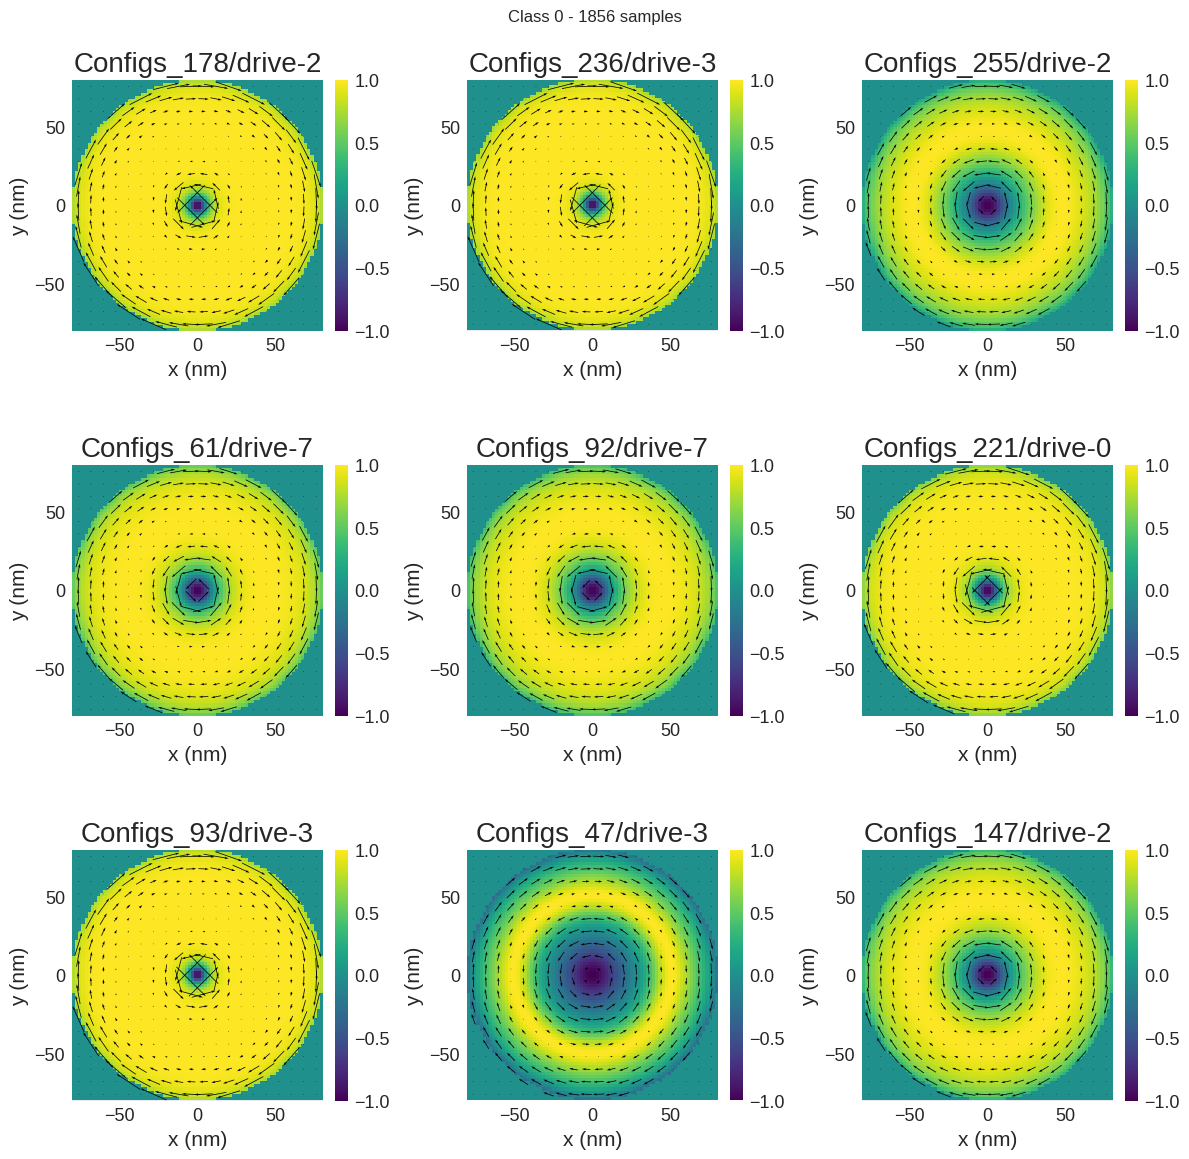

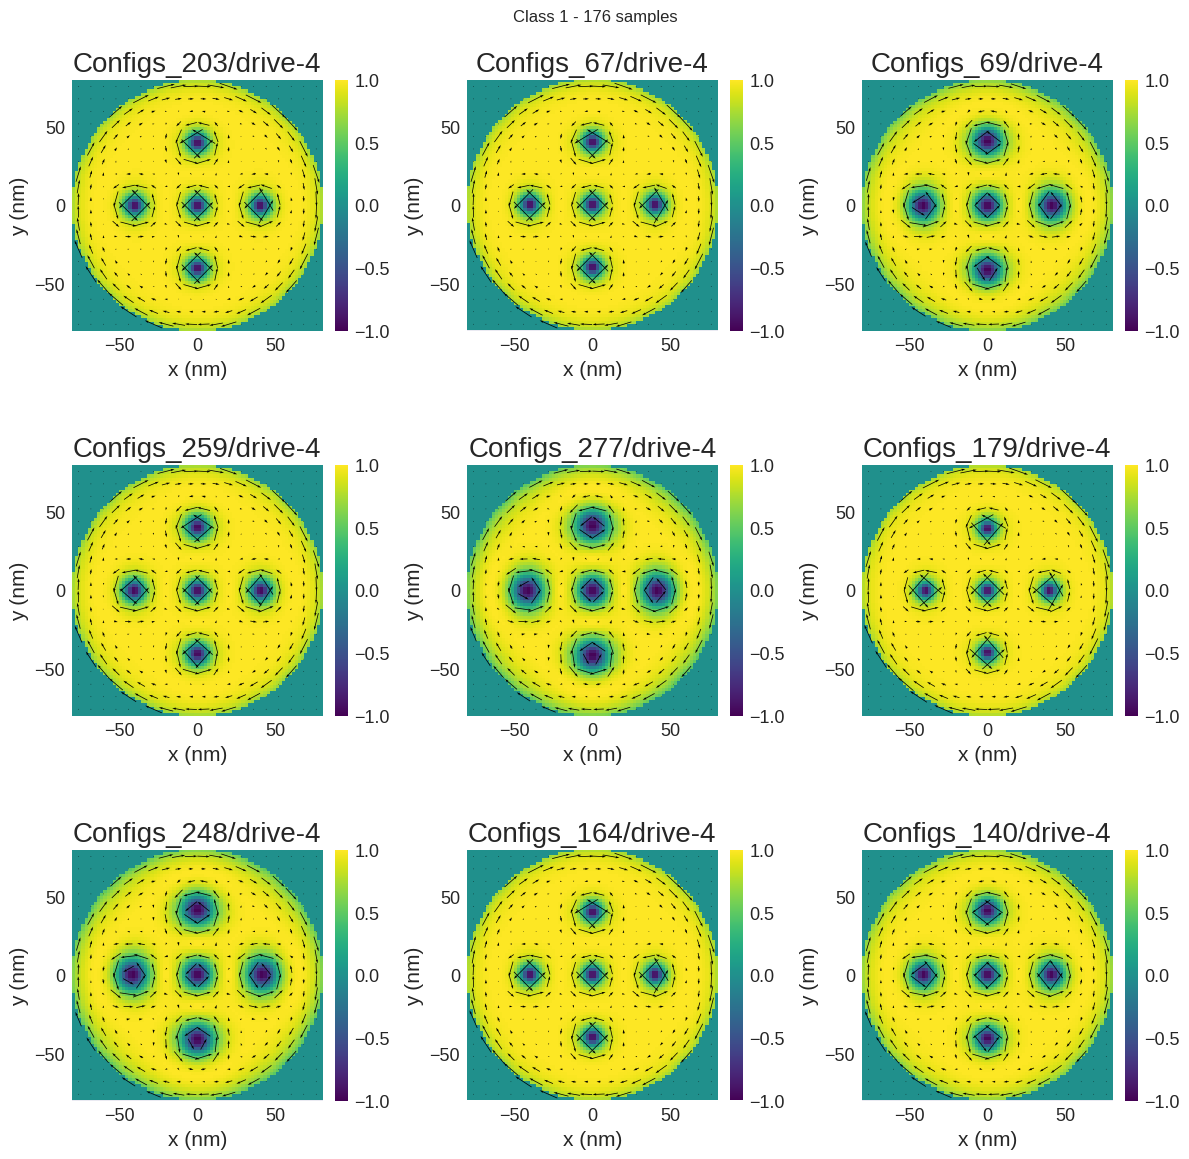

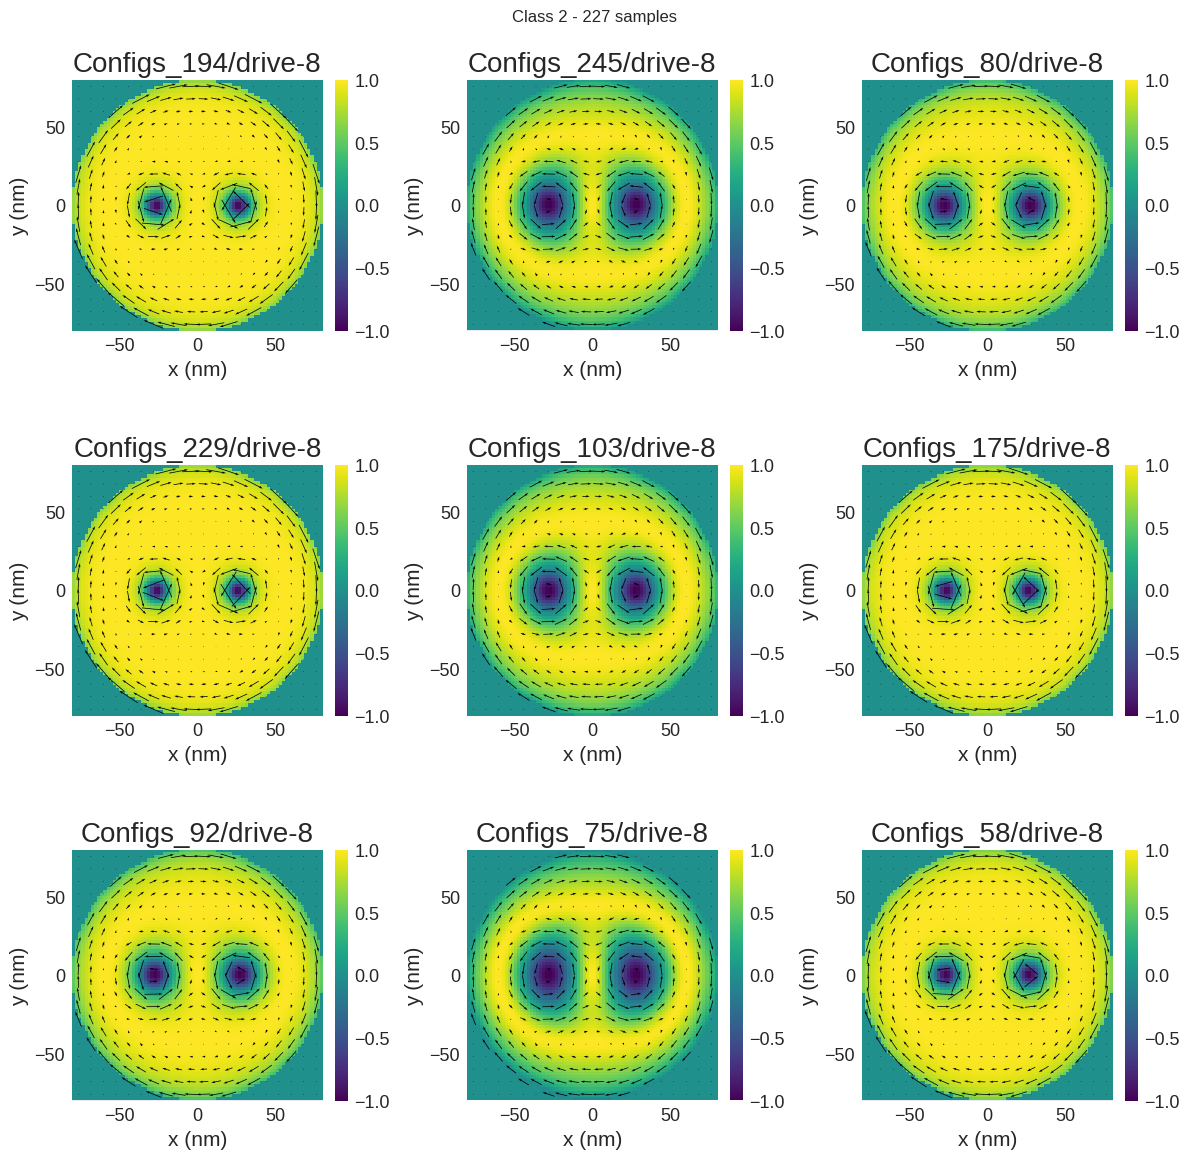

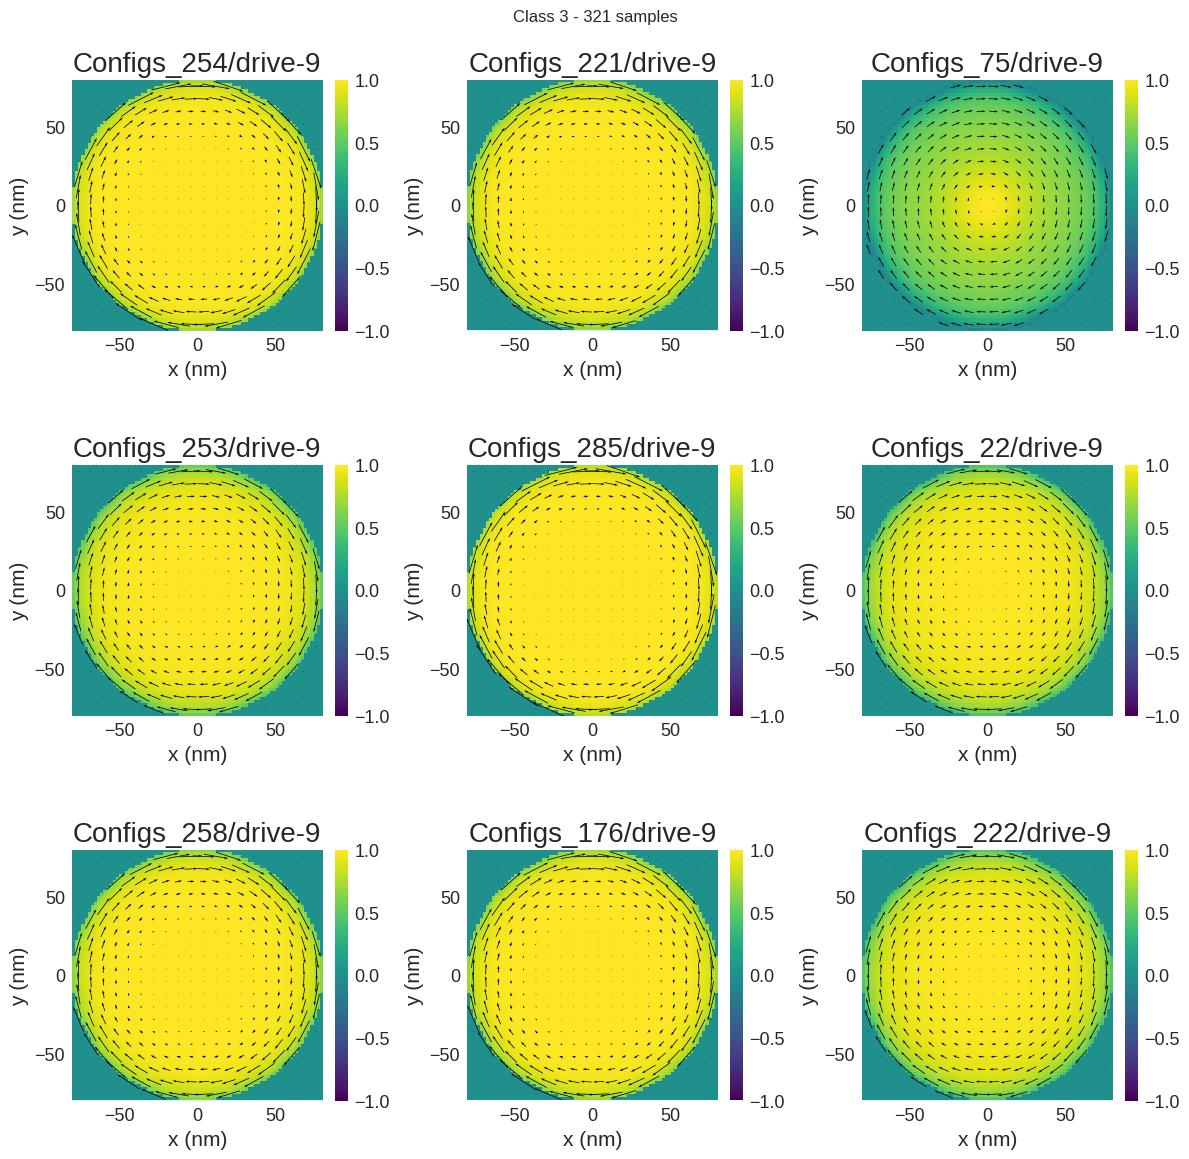

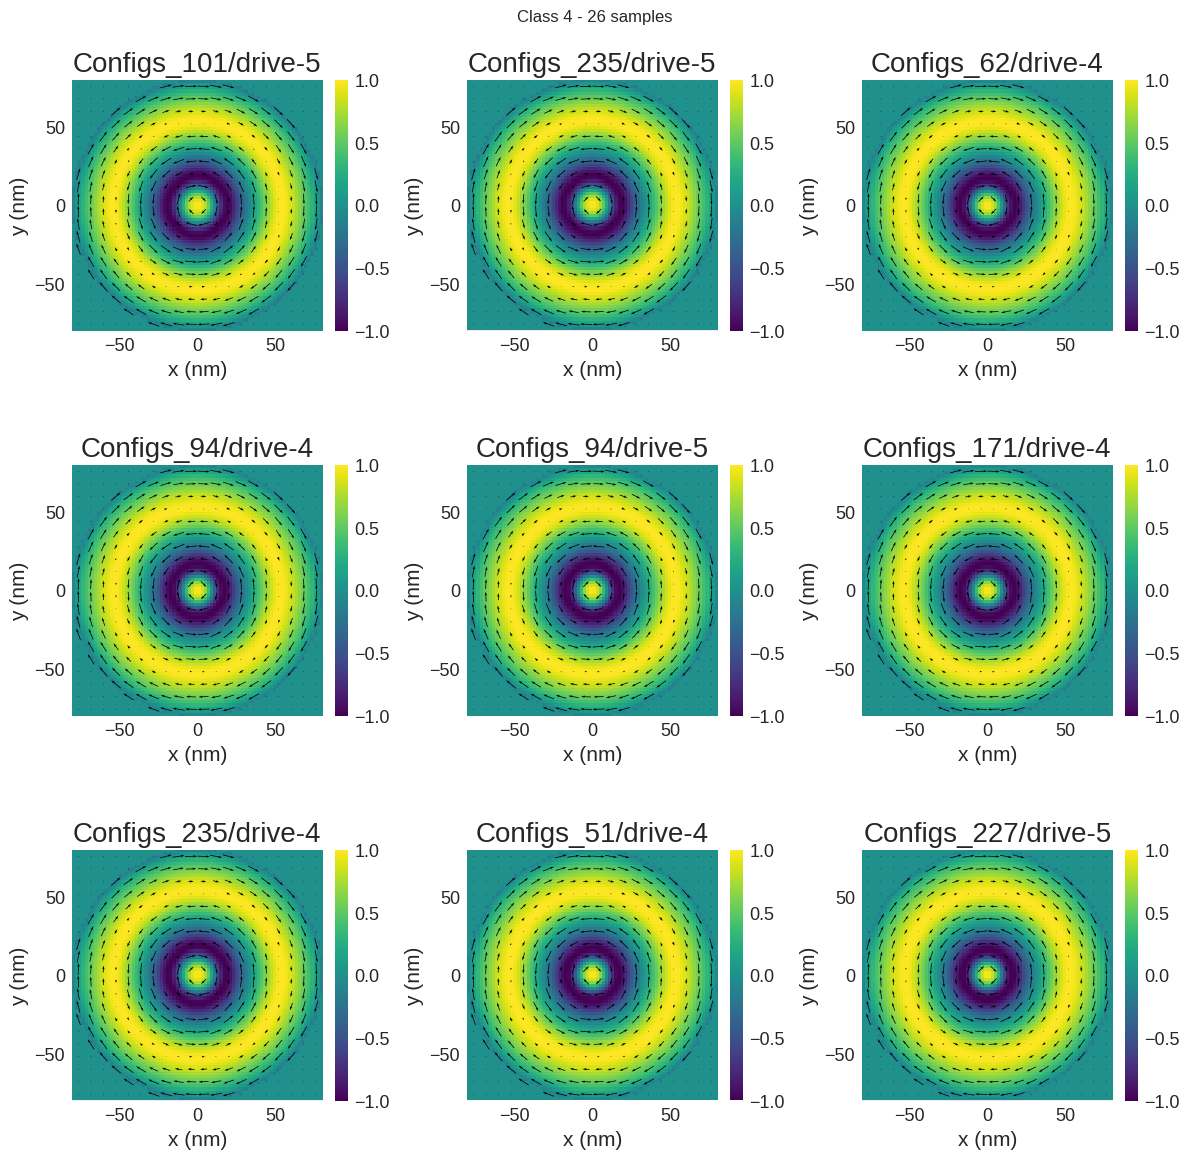

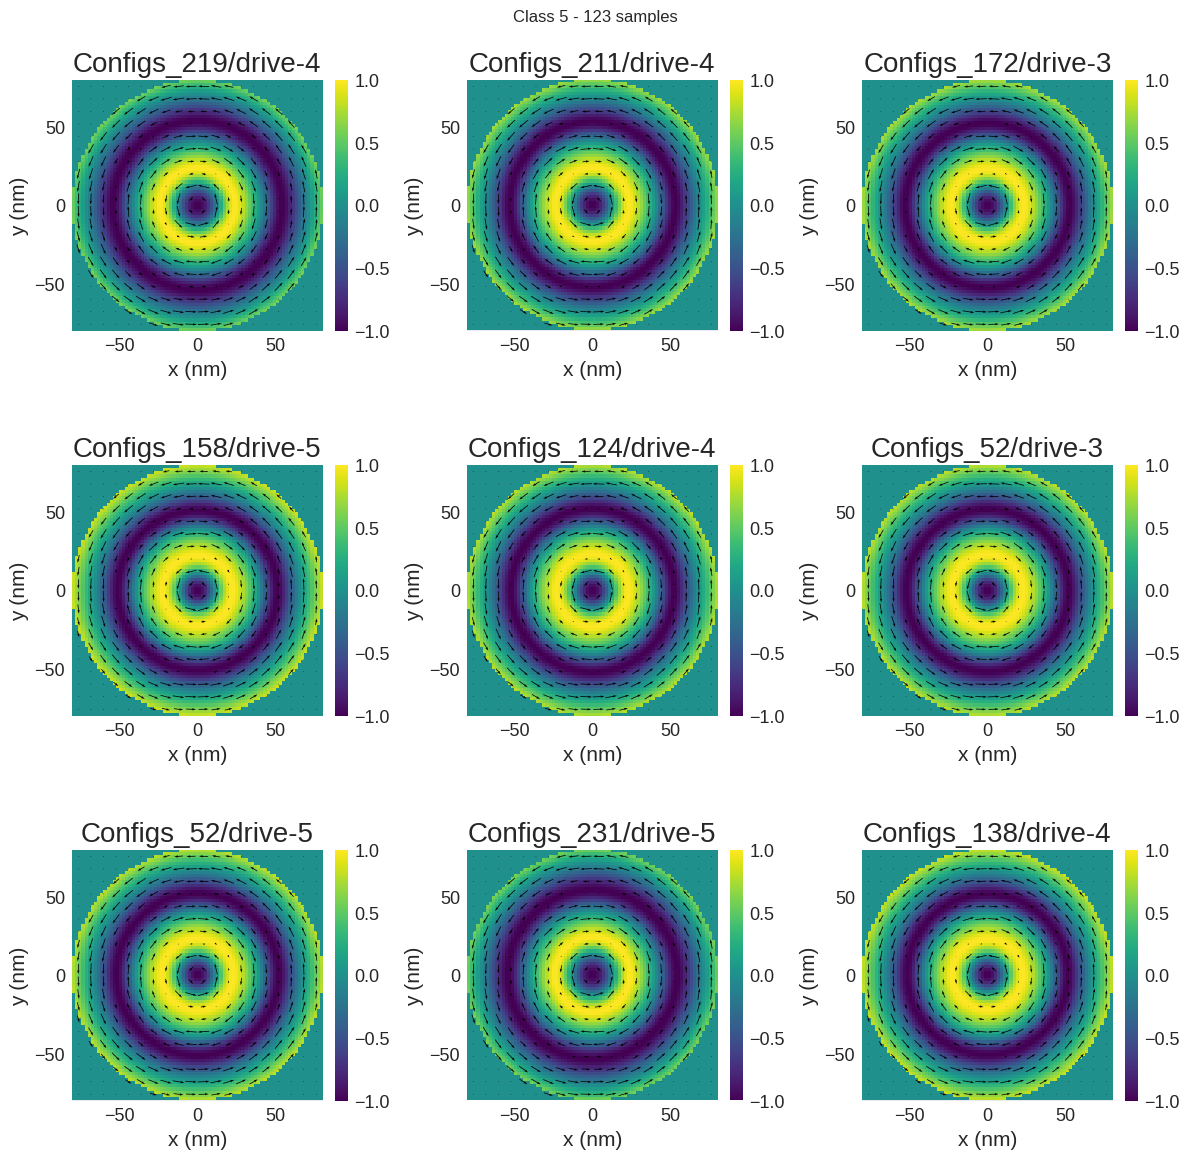

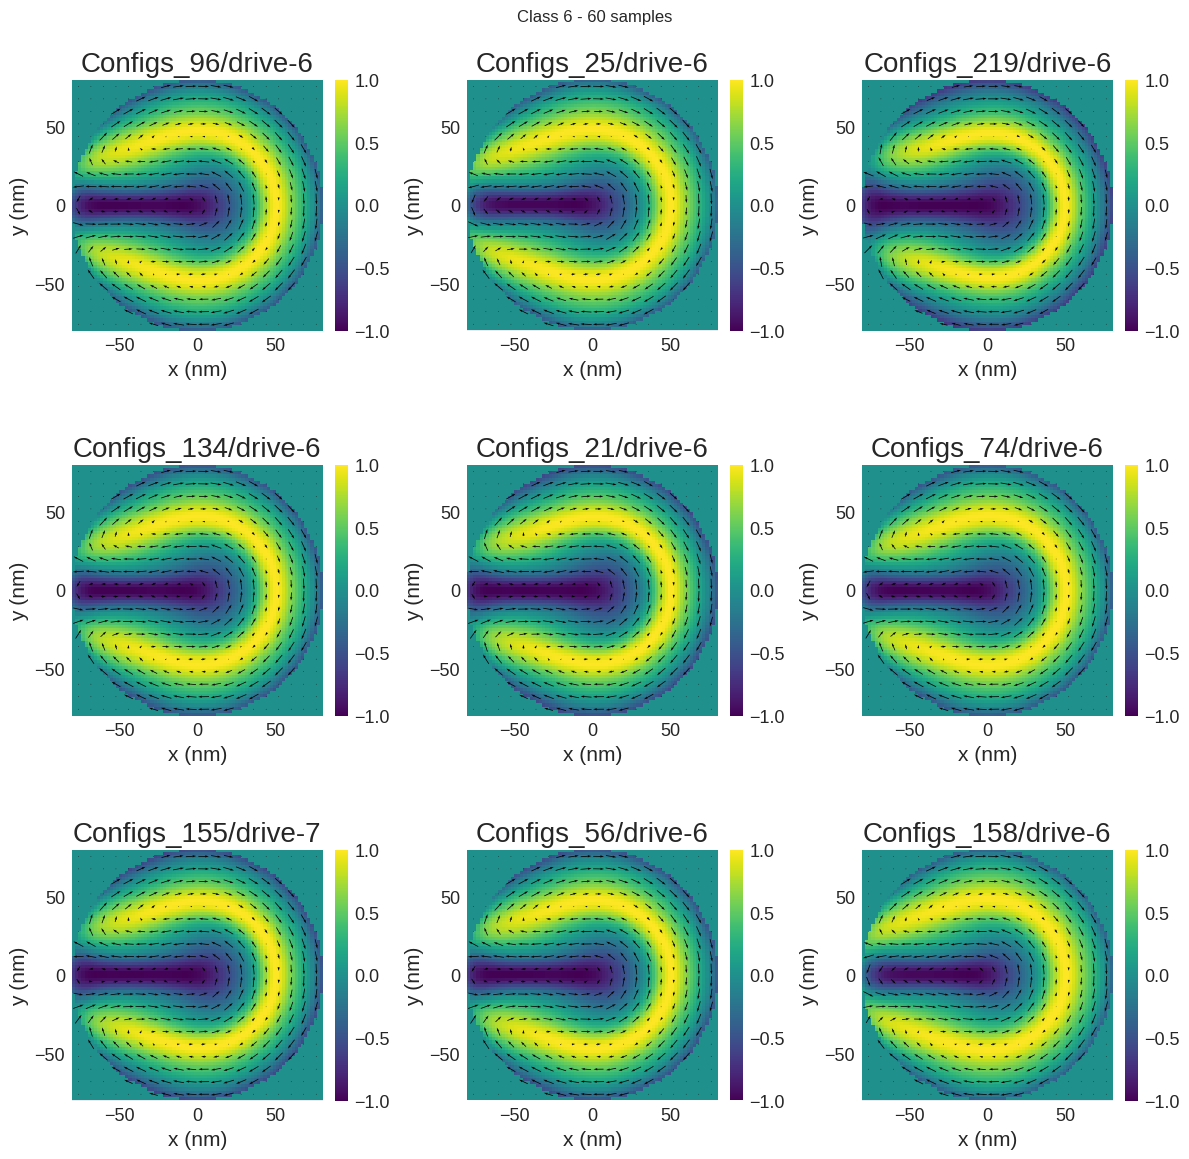

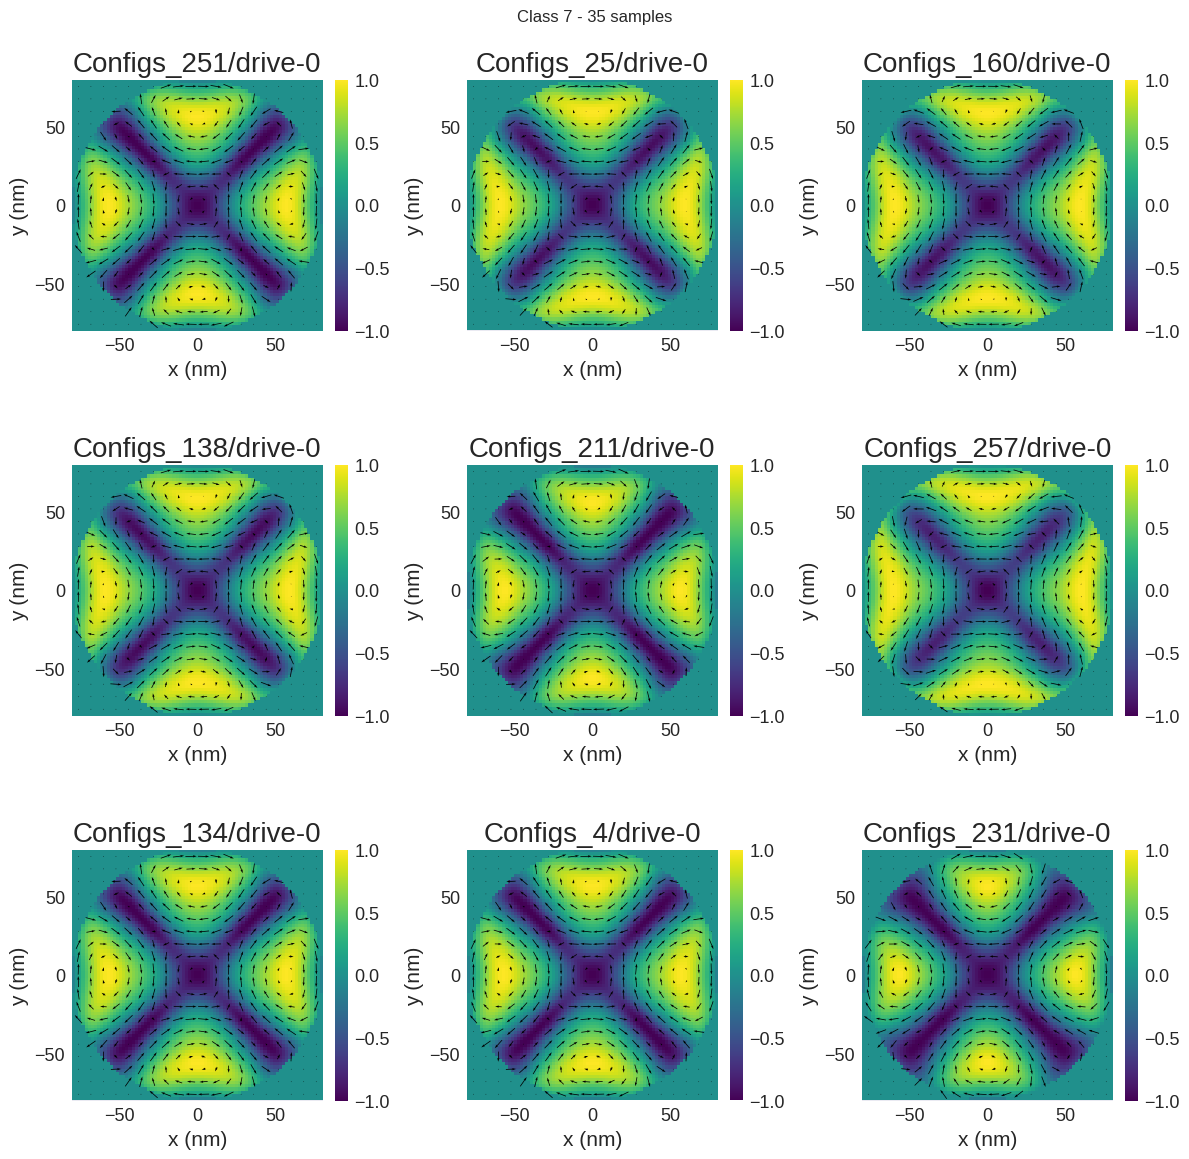

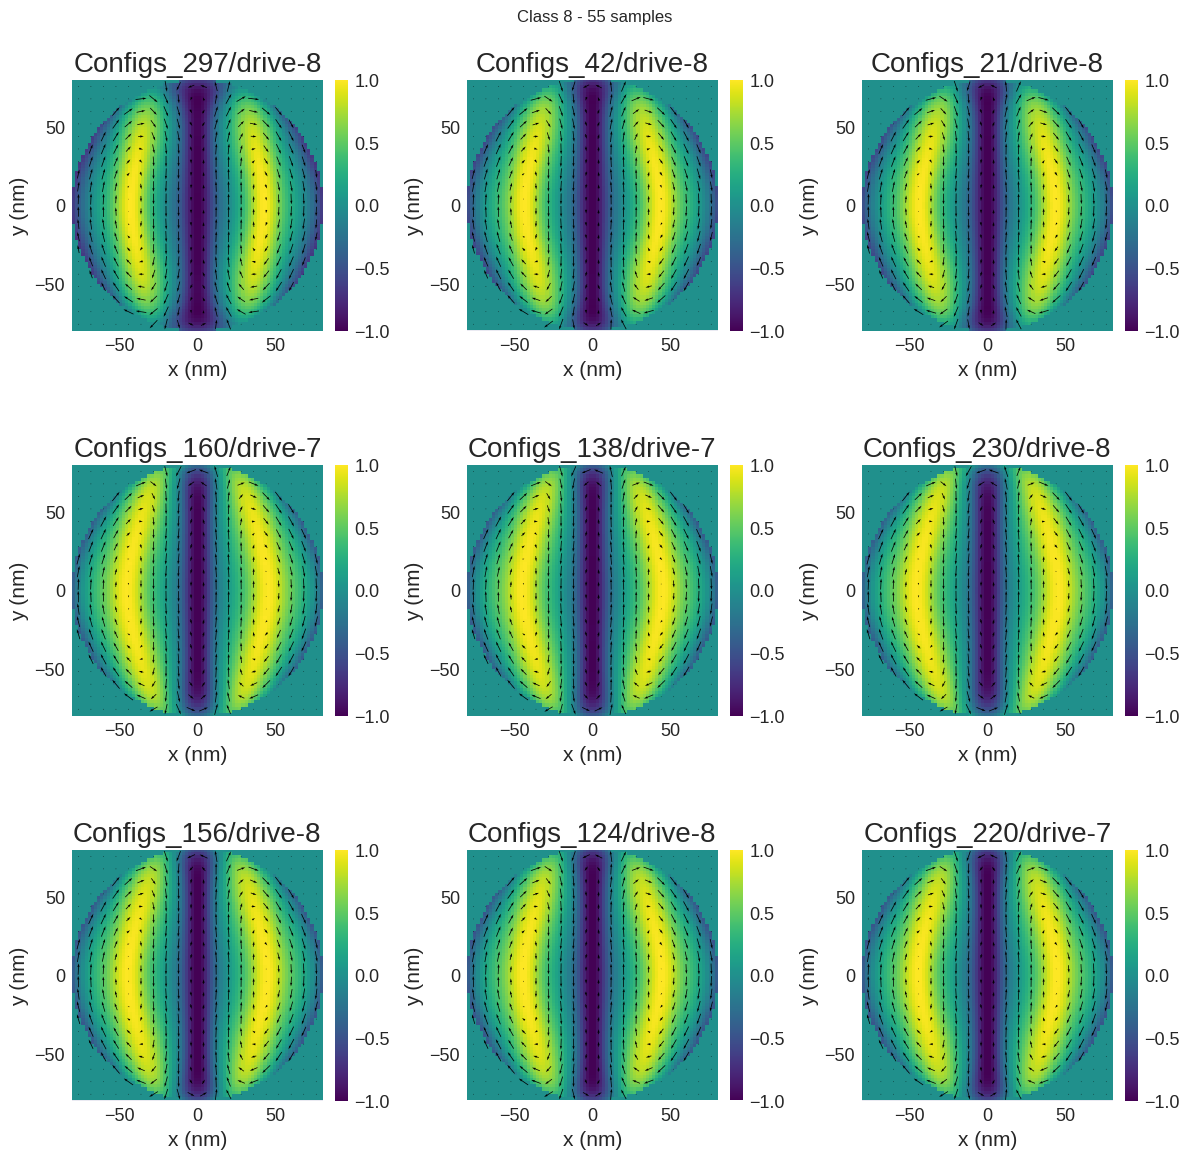

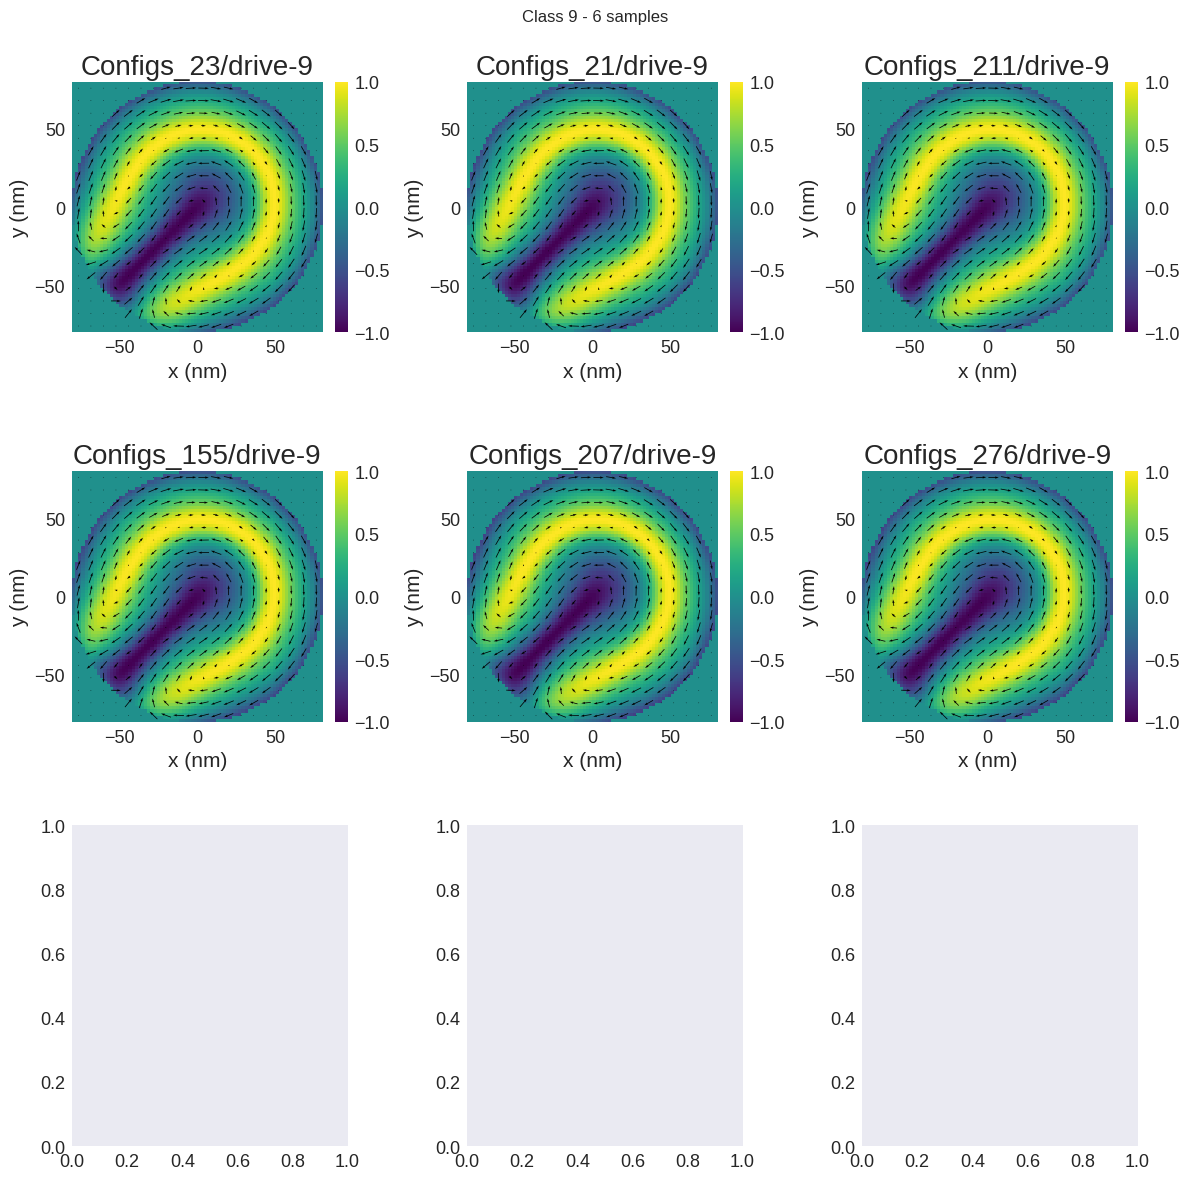

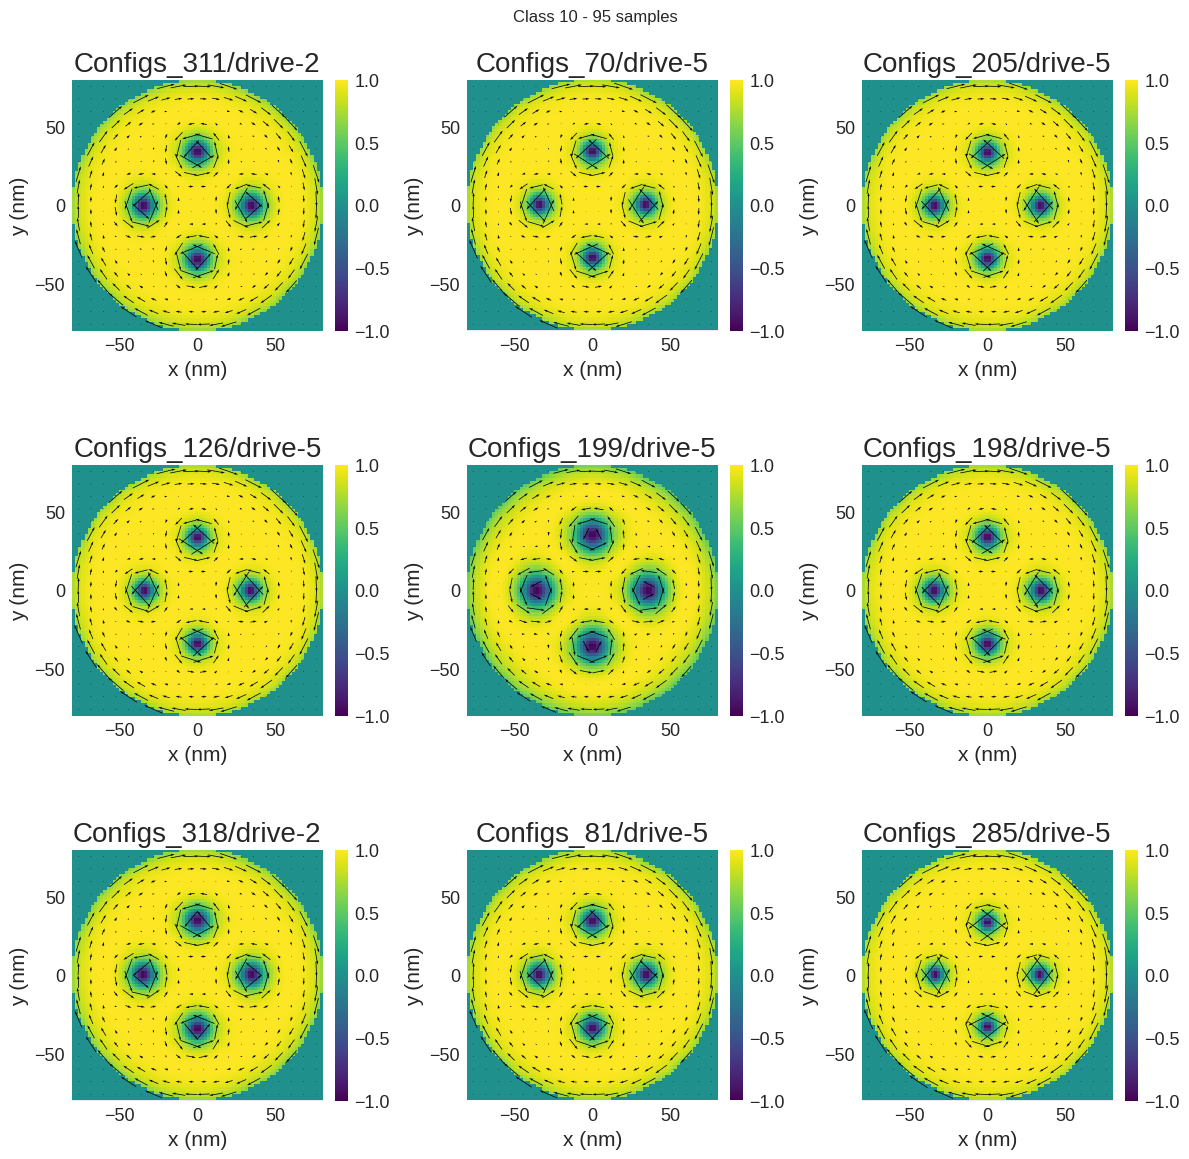

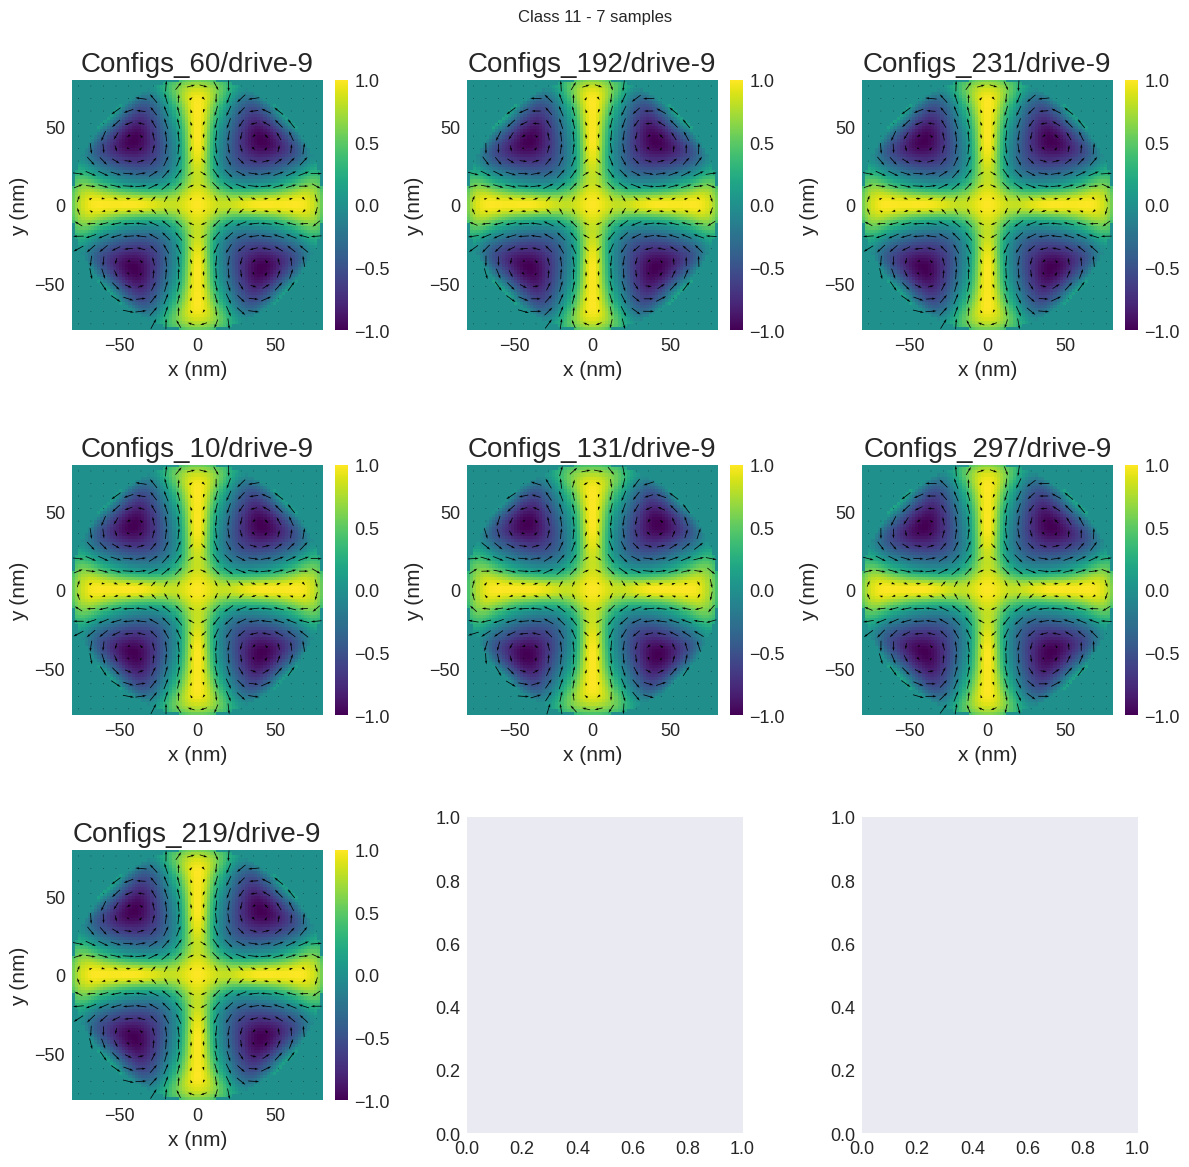

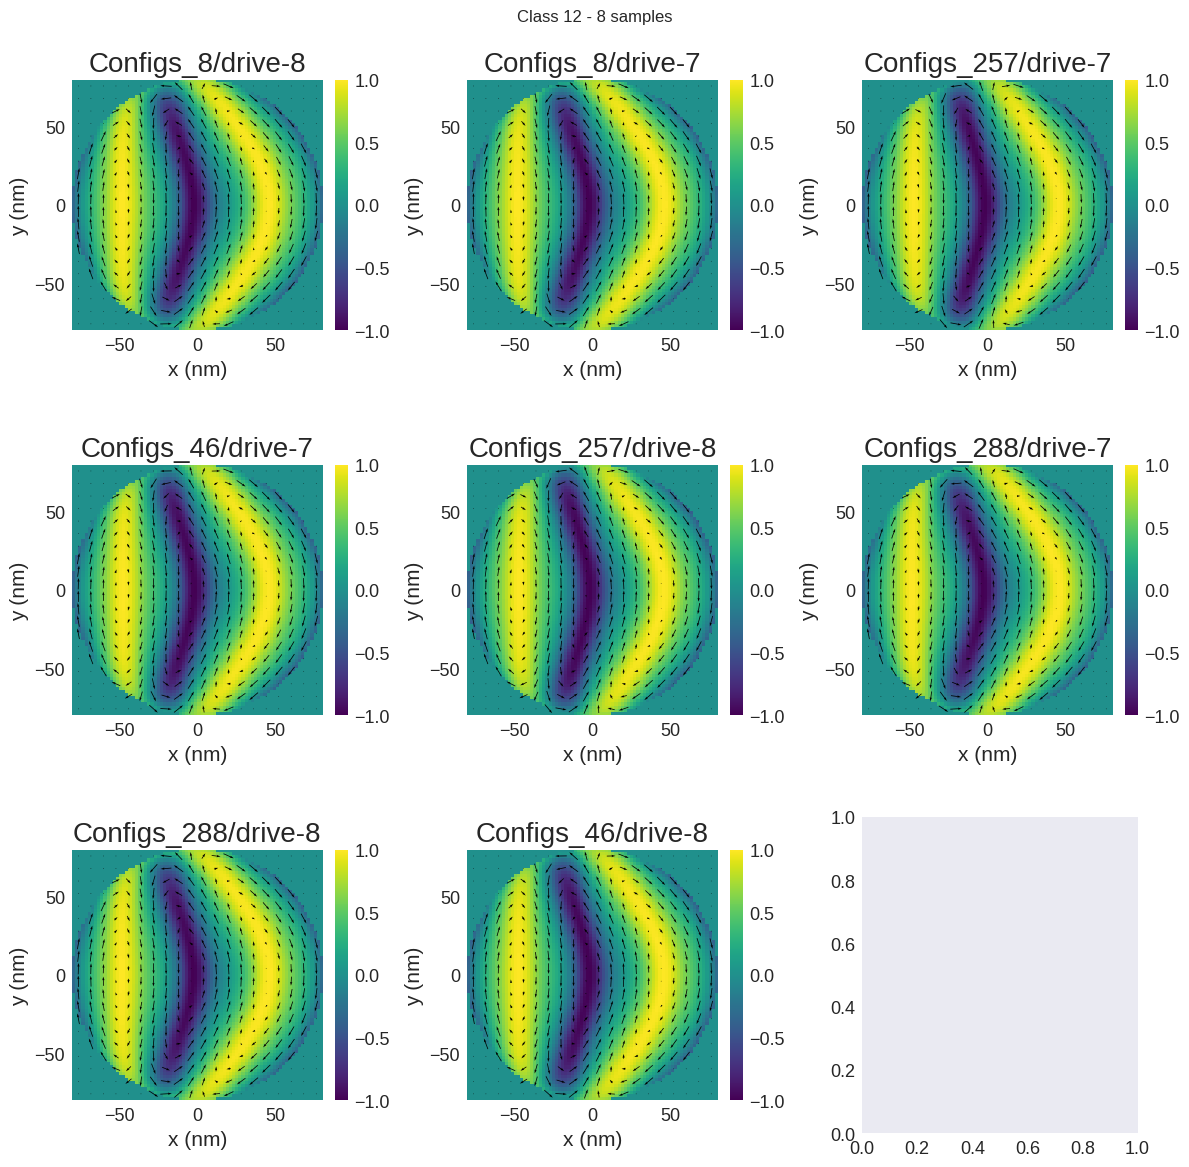

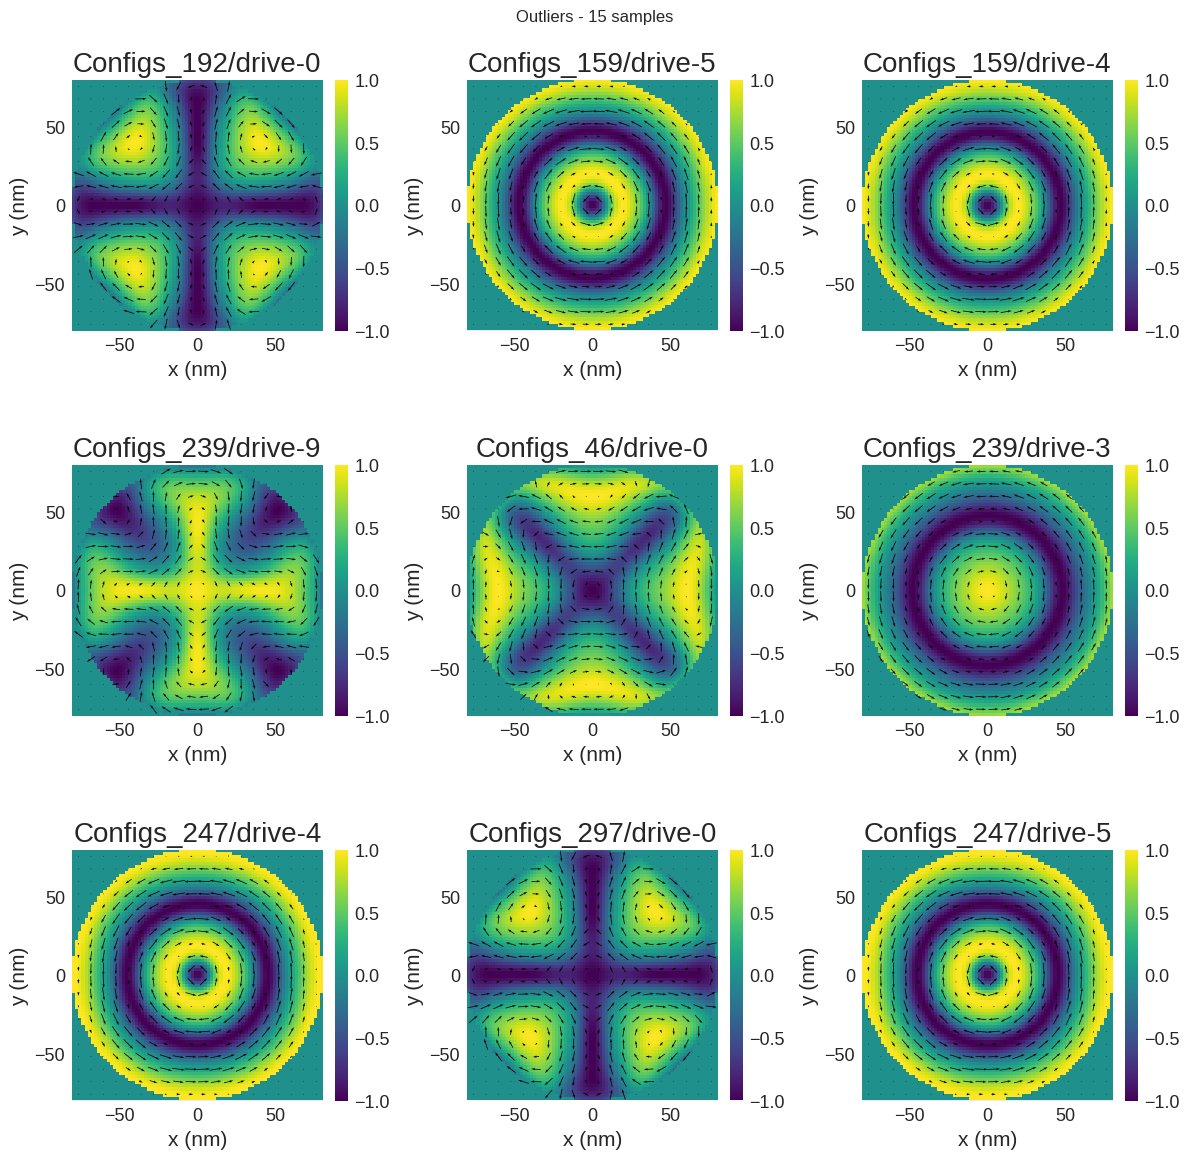

In [8]:
from plotting import plot_all_examples

plot_all_examples(class_dict, parameters_dict)

In [25]:
# kmeans clustering optimization
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def objective(trial):
    n_clusters = trial.suggest_int("n_clusters", 8, 20)
    # Replace 'distance_metric' with 'metric'
    metric = trial.suggest_categorical(
        "metric", ["euclidean", "manhattan", "cosine"])
    # Replace 'distance_metric' with 'metric'
    kmeans = KMeans(n_clusters=n_clusters, metric=metric, random_state=42)
    labels = kmeans.fit_predict(feature_arr)
    metric = silhouette_score(feature_arr, labels)
    return metric


study = optuna.create_study(direction="maximize", study_name="KMeans_ss",
                            storage="sqlite:///kmeans_ss.db", load_if_exists=True)
study.optimize(objective, n_trials=100)

[I 2024-03-15 12:41:30,074] Using an existing study with name 'KMeans_ss' instead of creating a new one.
[W 2024-03-15 12:41:30,362] Trial 203 failed with parameters: {'n_clusters': 19, 'metric': 'euclidean'} because of the following error: TypeError("KMeans.__init__() got an unexpected keyword argument 'metric'").
Traceback (most recent call last):
  File "/home/tux/optim/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_44662/860270880.py", line 8, in objective
    kmeans = KMeans(n_clusters=n_clusters, metric=metric, random_state=42)  # Replace 'distance_metric' with 'metric'
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: KMeans.__init__() got an unexpected keyword argument 'metric'
[W 2024-03-15 12:41:30,363] Trial 203 failed with value None.


TypeError: KMeans.__init__() got an unexpected keyword argument 'metric'

In [ ]:
kmeans = KMeans(study.best_params["n_clusters"])

kmeans.fit(feature_arr)
print(kmeans.n_clusters)

import plotly.graph_objs as go
import plotly.express as ptx

class_dict = {f"Class {i}": list() for i in range(kmeans.n_clusters + 1)}
class_dict["Outliers"] = list()
for index, path in enumerate(simulation_file_paths):
    class_ = kmeans.labels_[index]
    if class_ == -1:
        class_dict["Outliers"].append(str(path))
    else:
        class_dict[f"Class {class_}"].append(str(path))

traces = list()
for class_id, colour in zip(class_dict, ptx.colors.qualitative.Dark24):
    traces.append(
        go.Scatter(
            x=[
                parameters_dict[f]["H"]
                for f in class_dict[class_id]
            ],
            y=[
                parameters_dict[f]["E"]
                for f in class_dict[class_id]
            ],
            mode="markers",
            name=class_id,
            opacity=0.7,
            marker=dict(
                size=11,
                color=colour,
            ),
        )
    )

fig = go.Figure(data=traces)
fig.update_layout(
    autosize=False,
    width=990,
    height=600,
    margin=dict(
        l=10,
        r=10,
        b=25,
        t=25,
    ),
    xaxis_title=r"$\mu_0 \mathbf{H} \text{ (T)}$",
    yaxis_title=r"$\Delta \text{E (J)}$",
)

20


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#2E91E5', 'size': 11},
              'mode': 'markers',
              'name': 'Class 0',
              'opacity': 0.7,
              'type': 'scatter',
              'x': [0.7108584663581602, 1.0250054051919253, 1.0520917899467686,
                    0.9646048372886914, 0.9207083700108073, 0.7015080933424875,
                    1.1929253724128137, 0.746403496136002, 1.0976181620612193,
                    1.1469998419153746, 0.9808002518152286, 0.9291651296158059,
                    0.7125494922138771, 0.9249011197760583, 0.836415867916509,
                    0.720271961003612, 1.1141259767768092, 1.1071872073552032,
                    1.1086917079049514, 1.1955561140906563, 0.8202076505365383,
                    0.9864011704620863, 0.7453627241490277, 1.1305127224462546,
                    0.8197104804685906, 1.0847157664043714, 0.7867600810417402,
                    1.0202856143980115, 0.8028197934355251, 1.1954039370060294,
                    0.8347188180131706, 1.0138643716232256, 0.8362432922424539,
                    0.9066727290485987, 0.7520385821733719, 0.8775627476181801,
                    1.1735348343250152, 0.8115632219784964, 0.7038115819871134,
                    1.1827621140750701, 0.9130732008672463, 1.1661932580993006,
                    1.1090159870748109, 0.790605703246432, 0.9269515687798381,
                    0.9698279207025753, 1.1770707825786892, 1.116615272717344,
                    1.0718182521919446, 0.8843678484873443, 0.9641370033042524,
                    1.0505179873860966, 0.8027673907963068, 1.1402152872098037,
                    0.7474323434833914, 0.8237846523064629, 0.9581704014515433,
                    1.0706344716555656, 0.7897525671244984, 0.9935376695424457,
                    0.8850705377887228, 0.9742161584909454, 0.6997767539785071,
                    0.7983981074624066, 1.173866898580667, 0.8204690678947646,
                    1.0934684341269973, 1.0515676079188805, 0.7179679094332169,
                    0.9898962581019028, 1.112307266850654, 1.140888569640036,
                    1.0282460428447024, 0.9981815390658192, 0.8637599795213791,
                    0.9448716255746837, 0.9953320671441747, 0.9951803409357836,
                    1.1603903092753214, 0.9861663886355949, 1.1120120774019429,
                    1.1122117803842337, 1.0465188935411227, 1.016188363672831,
                    0.7302987445748806, 0.9586195626295599, 1.1947724585988408,
                    1.0274713182492725, 0.7506798559997826, 0.7571489064156133,
                    0.7526268782292636, 0.8160392176894741, 0.7327626429589381,
                    0.9813592490631781, 0.809569514778482, 1.0469586493867697,
                    0.9440337622094458, 1.0485608360241712, 0.9965448251651002,
                    0.7288630436479365, 0.9553442344939065, 0.8049275669085849,
                    0.7528928307335971, 1.1665884152288912, 0.7464990043310208,
                    1.0636166570397383, 0.8477523637167386, 1.0273665437929667,
                    0.694413890698619, 0.814596005866179, 1.1814759805272004,
                    0.7541989561392994, 0.7140948789521357, 0.8081036758866661,
                    0.8519665292898678, 0.869261412570817, 1.017422486013861],
              'y': [8.53124411599999e-19, 2.4052888850999946e-18,
                    2.4951431111000026e-18, 2.180636886800005e-18,
                    1.994918385600001e-18, 7.953826883999966e-19,
                    2.8679891561000005e-18, 1.070010236100001e-18,
                    2.632159098500011e-18, 2.7624463275999986e-18,
                    2.2442933438999935e-18, 2.0322206520999975e-18,
                    8.635453358999991e-19, 2.0135041163999985e-18,
                    1.5829597289999965e-18, 9.110306113999994e-19,
                    2.6777485824000046e-18, 2.658841521700005e-18,
                    2.6629723006000087e-18, 2.8736048295999945e-18,
                    1.49561

In [14]:
# agglomerative clustering optimization
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


def objective(trial):
    n_clusters = trial.suggest_int("n_clusters", 8, 20)
    linkage = trial.suggest_categorical(
        "linkage", ["ward", "complete", "average", "single"])
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    labels = agg.fit_predict(feature_arr)
    metric = silhouette_score(feature_arr, labels)
    return metric


study = optuna.create_study(direction="maximize", study_name="Agglomerative_ss",
                            storage="sqlite:///agglomerative_ss.db", load_if_exists=True)
study.optimize(objective, n_trials=100)

[I 2024-03-15 11:54:58,063] A new study created in RDB with name: Agglomerative_ss
[I 2024-03-15 11:54:58,389] Trial 0 finished with value: 0.4910692274570465 and parameters: {'n_clusters': 9, 'linkage': 'ward'}. Best is trial 0 with value: 0.4910692274570465.
[I 2024-03-15 11:54:58,697] Trial 1 finished with value: 0.5232890248298645 and parameters: {'n_clusters': 17, 'linkage': 'complete'}. Best is trial 1 with value: 0.5232890248298645.
[I 2024-03-15 11:54:58,963] Trial 2 finished with value: 0.30795297026634216 and parameters: {'n_clusters': 18, 'linkage': 'single'}. Best is trial 1 with value: 0.5232890248298645.
[I 2024-03-15 11:54:59,214] Trial 3 finished with value: 0.17840838432312012 and parameters: {'n_clusters': 15, 'linkage': 'single'}. Best is trial 1 with value: 0.5232890248298645.
[I 2024-03-15 11:54:59,501] Trial 4 finished with value: 0.5131610631942749 and parameters: {'n_clusters': 14, 'linkage': 'average'}. Best is trial 1 with value: 0.5232890248298645.
[I 2024-03

In [21]:
import plotly.express as ptx
import plotly.graph_objs as go
Ag_cluster = AgglomerativeClustering(
    n_clusters=study.best_params["n_clusters"], linkage=study.best_params["linkage"])
Ag_cluster_labels = Ag_cluster.fit_predict(feature_arr)
print(Ag_cluster.n_clusters)


class_dict = {f"Class {i}": list() for i in range(Ag_cluster.n_clusters + 1)}
class_dict["Outliers"] = list()

for index, path in enumerate(simulation_file_paths):
    class_ = Ag_cluster.labels_[index]
    if class_ == -1:
        class_dict["Outliers"].append(str(path))
    else:
        class_dict[f"Class {class_}"].append(str(path))

traces = list()
for class_id, colour in zip(class_dict, ptx.colors.qualitative.Dark24):
    traces.append(
        go.Scatter(
            x=[
                parameters_dict[f]["H"]
                for f in class_dict[class_id]
            ],
            y=[
                parameters_dict[f]["E"]
                for f in class_dict[class_id]
            ],
            mode="markers",
            name=class_id,
            opacity=0.7,
            marker=dict(
                size=11,
                color=colour,
            ),
        )
    )

fig = go.Figure(data=traces)
fig.update_layout(
    autosize=False,
    width=990,
    height=600,
    margin=dict(
        l=10,
        r=10,
        b=25,
        t=25,
    ),
    xaxis_title=r"$\mu_0 \mathbf{H} \text{ (T)}$",
    yaxis_title=r"$\Delta \text{E (J)}$",
)

20


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#2E91E5', 'size': 11},
              'mode': 'markers',
              'name': 'Class 0',
              'opacity': 0.7,
              'type': 'scatter',
              'x': [0.4175134329531739, 0.4175134329531739, 0.4175134329531739,
                    ..., 0.5019182295899718, 0.5019182295899718,
                    0.5019182295899718],
              'y': [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]},
             {'marker': {'color': '#E15F99', 'size': 11},
              'mode': 'markers',
              'name': 'Class 1',
              'opacity': 0.7,
              'type': 'scatter',
              'x': [0.27819278671534964, 0.27819278671534964, 0.280929955271993,
                    0.280929955271993, 0.10404936148175352, 0.10404936148175352,
                    0.07527286362065425, 0.07527286362065425, 0.07527286362065425,
                    0.12314500844208708, 0.12314500844208708, 0.1200051235924728,
                    0.1200051235924728, 0.06415061172236722, 0.06415061172236722,
                    0.06415061172236722, 0.16233320056405595, 0.16233320056405595,
                    0.16233320056405595, 0.05767995912901584, 0.05767995912901584,
                    0.05767995912901584, 0.029335013094577887,
                    0.029335013094577887, 0.13930175741253814, 0.13930175741253814,
                    0.09896463765738081, 0.09896463765738081,
                    0.0045748663348678335, 0.0045748663348678335,
                    0.0049577451594033485, 0.0049577451594033485,
                    0.13120496795805647, 0.13120496795805647, 0.2794146286864358,
                    0.2794146286864358, 0.048397381135607716, 0.048397381135607716,
                    0.048397381135607716, 0.12152269818476434, 0.12152269818476434,
                    0.16160298068677026, 0.16160298068677026, 0.16160298068677026,
                    0.24864339638663877, 0.24864339638663877, 0.09520598533519938,
                    0.09520598533519938, 0.10862032555585044, 0.10862032555585044,
                    0.2521333701349106, 0.2521333701349106, 0.12024626663464288,
                    0.12024626663464288, 0.05556525292833445, 0.05556525292833445,
                    0.2864676985120365, 0.2864676985120365, 0.020055601051892014,
                    0.020055601051892014, 0.012202489987678432,
                    0.012202489987678432, 0.27203913743067176, 0.27203913743067176,
                    0.2740370301783385, 0.2740370301783385, 0.01842989869844196,
                    0.01842989869844196, 0.0680853551098887, 0.0680853551098887,
                    0.0680853551098887, 0.09343237728599144, 0.09343237728599144,
                    0.1290774946406727, 0.1290774946406727, 0.12282567902694742,
                    0.12282567902694742, 0.10628000491945659, 0.10628000491945659,
                    0.013790040024915795, 0.013790040024915795, 0.2780322901650048,
                    0.2780322901650048, 0.10282549835843335, 0.10282549835843335,
                    0.1467594265549136, 0.1467594265549136, 0.1467594265549136,
                    0.15679231120900416, 0.15679231120900416, 0.15679231120900416,
                    0.1511396584396841, 0.1511396584396841, 0.1511396584396841,
                    0.15675005568735337, 0.15675005568735337, 0.15675005568735337,
                    0.27785719330458286, 0.27785719330458286, 0.104560520146578,
                    0.104560520146578, 0.2797978667076925, 0.2797978667076925,
                    0.29010798832463125, 0.29010798832463125, 0.08067118301082754,
                    0.08067118301082754, 0.08067118301082754, 0.25887512480467534,
                    0.25887512480467534, 0.06405041147039583, 0.06405041147039583,
                    0.06405041147039583],
              'y': [2.0976509775e-18, 2.0976509775e-18, 2.1074058207000007e-18,
                    2.1074058207000007e-18, 0.0, 0.0, 0.0, 3.541616648999988e-19,
                    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.